
# 🛡️ Hybrid DGA Detection Model: FastText, CNN, BiLSTM & Multihead Attention
🚀 **High-performance deep learning model for detecting Domain Generation Algorithm (DGA) domains.**

This notebook implements a **hybrid deep learning model** combining:

✅ **FastText** for embeddings  
✅ **CNN** for feature extraction  
✅ **BiLSTM** for sequence modeling  
✅ **Multihead Attention** for advanced feature selection  

### 📌 Dataset:
- **Legitimate domains**: Alexa Top 1M (1M samples)  
- **DGA domains**: 360 Netlab dataset (1M samples)  

---


In [ ]:

# Install dependencies if not already installed
!pip install tensorflow torch torchvision torchaudio torchtext seaborn scikit-learn pandas numpy matplotlib tqdm

# Import Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Conv1D, LSTM, Bidirectional, Dense, GlobalMaxPooling1D, Input, MultiHeadAttention, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve
from google.colab import drive

print("All dependencies successfully imported! 🚀")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.2 MB/s eta 0:00:00
All dependencies successfully imported! 🚀


In [ ]:

# Mount Google Drive to access the dataset
drive.mount('/content/drive')

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/360&Alexa.csv')

# Display first few rows
df.head()


Mounted at /content/drive


,DGA_family,Domain,Type
0,banjori,moigsagabardinedazyx.com,DGA
1,emotet,hkhwrwmesopcwihp.eu,DGA
2,emotet,iisqiqxebeakrhhm.eu,DGA
3,tinba,pwveutodeooo.net,DGA
4,rovnix,knmy8qdwubpq7a6grs.com,DGA


**📌 Step 3: Data Preprocessing**

In [ ]:
# Shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)

# Convert categorical labels to integers
df['label'] = df['Type'].map({'Legitimate': 0, 'DGA': 1})  # 0 = Legitimate (Alexa), 1 = DGA (360 Netlab)

# Tokenization: Convert domain names into sequences
tokenizer = Tokenizer(char_level=True)  # Character-level tokenization
tokenizer.fit_on_texts(df['Domain'])
sequences = tokenizer.texts_to_sequences(df['Domain'])

# Padding sequences to the max length found
MAX_LEN = max(len(seq) for seq in sequences)
X = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# Extract labels
y = df['label'].values  # Ensure labels are integer (0 = Legit, 1 = DGA)

# Train-Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print dataset statistics
print(f"✅ Dataset Loaded: {len(df)} samples")
print(f"✅ Label Distribution: Legitimate={sum(df['label'] == 0)}, DGA={sum(df['label'] == 1)}")
print(f"✅ Data split: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

✅ Dataset Loaded: 2000000 samples
✅ Label Distribution: Legitimate=1000000, DGA=1000000
✅ Data split: Train=1600000, Val=200000, Test=200000


**📌 Step 4: Build the Hybrid Model**

In [ ]:

# Define Model
input_layer = Input(shape=(MAX_LEN,))

# Embedding Layer
embedding_layer = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=300, input_length=MAX_LEN, trainable=True)(input_layer)

# CNN Layer
cnn_layer = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(embedding_layer)
cnn_layer = GlobalMaxPooling1D()(cnn_layer)

# BiLSTM Layer
bilstm_layer = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)

# Multihead Attention Layer
attention_layer = MultiHeadAttention(num_heads=4, key_dim=128)(bilstm_layer, bilstm_layer)
attention_layer = LayerNormalization(epsilon=1e-6)(attention_layer)

# Concatenate Layers
concat_layer = tf.keras.layers.Concatenate()([cnn_layer, GlobalMaxPooling1D()(attention_layer)])

# Fully Connected Layers
dense_layer = Dense(128, activation='relu')(concat_layer)
dense_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)

# Compile Model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 73)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 73, 300)   │     12,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 73, 256)   │    439,296 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 73, 256)   │    526,080 │ bidirectional[0]… │
│ (MultiHeadAttentio… │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 73, 128)   │    115,328 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 73, 256)   │        512 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ layer_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     49,280 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,142,625 (4.36 MB)

 Trainable params: 1,142,625 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

**📌 Step 5: Train the Model**

In [ ]:

# Train Model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=256)

# Save Model
model.save('/content/drive/MyDrive/Colab Notebooks/dga_detection_model.h5')


Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 131s 21ms/step - accuracy: 0.9951 - loss: 0.0143 - val_accuracy: 0.9942 - val_loss: 0.0175
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 130s 21ms/step - accuracy: 0.9954 - loss: 0.0133 - val_accuracy: 0.9947 - val_loss: 0.0185
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 130s 21ms/step - accuracy: 0.9959 - loss: 0.0120 - val_accuracy: 0.9949 - val_loss: 0.0154
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 130s 21ms/step - accuracy: 0.9961 - loss: 0.0116 - val_accuracy: 0.9947 - val_loss: 0.0168
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 130s 21ms/step - accuracy: 0.9965 - loss: 0.0102 - val_accuracy: 0.9948 - val_loss: 0.0187
Epoch 6/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 130s 21ms/step - accuracy: 0.9967 - loss: 0.0097 - val_accuracy: 0.9950 - val_loss: 0.0180
Epoch 7/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 130s 21ms/step - accuracy: 0.9968 - loss: 0.0094 - val_accuracy: 0.9949 - val_loss: 0.0167
Epoch 8/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 130s 21ms/step - accuracy: 

**📌 Step 6: Evaluate the Model**

In [ ]:

# Model Evaluation
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Compute Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


6250/6250 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step
Accuracy: 0.9938
Precision: 0.9969
Recall: 0.9907
F1 Score: 0.9938
ROC AUC: 0.9997


**📌 Step 7: Visualizations**

**🔹 7.1 Confusion Matrix**

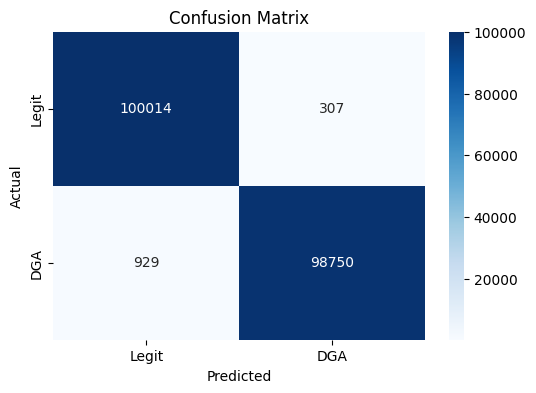

In [ ]:

# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Legit", "DGA"], yticklabels=["Legit", "DGA"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig('/content/drive/MyDrive/confusion_matrix.png', dpi=300)
plt.show()


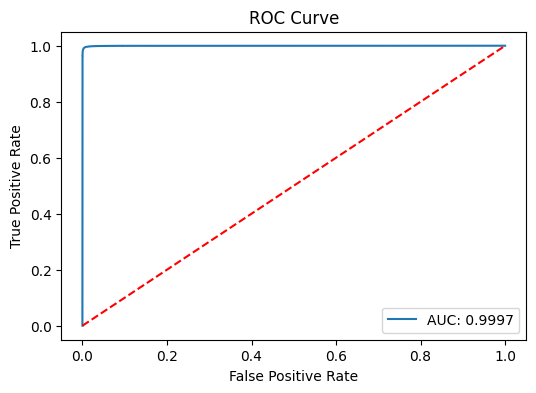

In [ ]:

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC: {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig('/content/drive/MyDrive/roc_curve.png', dpi=300)
plt.show()
